<a href="https://colab.research.google.com/github/CaptainJimbo/MyPortfolio/blob/main/musicGenerator2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install abcmidi timidity > /dev/null 2>&1
!apt-get install -y abcmidi timidity
!pip install pydub
!pip install IPython

# Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import regex as re

import os
import time
import functools
from tqdm import tqdm
import subprocess

from IPython import display as ipythondisplay
from IPython.display import Audio

# You better use a GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# Fetching data from the dropbox link
print('\nDownloading file...')
!wget -O music.abc "https://dl.dropboxusercontent.com/scl/fi/xyvgohdnz73uy0akyolsb/input.abc?rlkey=lcpg5bp57n46d7129qjprgnuy"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
abcmidi is already the newest version (20200122-1).
timidity is already the newest version (2.14.0-8build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.

--2023-07-18 09:59:46--  https://dl.dropboxusercontent.com/scl/fi/xyvgohdnz73uy0akyolsb/input.abc?rlkey=lcpg5bp57n46d7129qjprgnuy
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751713 (1.7M) [text/plain]
Saving to: ‘music.abc’

music.abc           100%[===================>]   1.67M  --.-KB/s    in 0.04s   

2023-07-18 09:59:47 (41.9 MB/s) - ‘music.abc’ saved [1751713/1751713]



In [ ]:
# open function inside a with statement so that the file gets closed after reading
with open('music.abc', 'r') as file:
    data = file.read()
# just to have the songs
songs = data.split('\n\n\n')
print(f'There are {len(songs)} songs in the file')

There are 4097 songs in the file


In [ ]:
def play(song):
    # writing the song to a new ABC file
    with open('song.abc', 'w') as file:
        file.write(song)
    # converting ABC to MIDI using subprocess
    subprocess.run(["abc2midi", "song.abc", "-o", "song.midi"])
    # converting MIDI to WAV
    subprocess.run(["timidity", "song.midi", "-Ow", "-o", "song.wav"])
    # load and play the audio file
    audio = Audio("song.wav")
    print(song,'\n')
    return audio

In [ ]:
print('Lets play the first song to see what\'s popping\n')
play(songs[0])

Lets play the first song to see what's popping

X: 1
T: The Enchanted Valley
M: 2/4
L: 1/16
B: "O'Neill's 1"
N: "Very slow" "collected by J. O'Neill"
N:
Z: "Transcribed by Norbert Paap, norbertp@bdu.uva.nl"
Z:
K:Gm
G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F4 (D2=E^F) |
G3-A (Bcd=e) | f4 d2-f2 | (g2a2 b2).g2 | {b}(a2g2 f2).d2 |
(d2{ed}c2) B2B2 | (A2G2 {AG}F2).D2 | (GABc) (d2{ed}c>A) | G2G2 G2z ||
G | B2c2 (dcAB) | G2G2 G3G | B2d2 (gfdc) | d2g2 (g3ga) |
(bagf) (gd)d>c | (B2AG) F-D.D2 | (GABc) d2d2 | (bgfd) cA.F2 |
G2A2 (B2{cB}AG) | A3-G F2-D2 | (GABc) (d2{ed}c>A) | G2G2 G2z2 || 



In [ ]:
# The algorithm doesn't understand characters it understands numbers i.e. it's just math!
# I will transform the characters to indices that will map to characters, but first I need the vocabulary
vocab = sorted(set(data))
print(f'Vocabulary of the abc file, i.e. chords, notes and others',''.join(vocab))

Vocabulary of the abc file, i.e. chords, notes and others 	
 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_abcdefghijklmnopqrstuvwxyz{|}~


In [ ]:
# Dictionary to map characters to indices
ch_to_idx = {char:idx for idx,char in enumerate(vocab)}
# Encode function to transform a string to a list of indices
encode = lambda string: [ch_to_idx[s] for s in string]

# Dictionary to map indices to characters
idx_to_ch = {idx:char for idx,char in enumerate(vocab)}
# Decode function to transform a ist of idxs to a string
decode = lambda digits: ''.join(idx_to_ch[d] for d in digits)

In [ ]:
# Try it
# encode('Hello There'), decode(encode('Hello There'))

In [ ]:
batch_size = 4
block_size = 20
vocab_size = len(vocab)
def get_batch(encoded_songs, batch_size, block_size):
    # String has length (len-1) because it starts from 0th place you need n
    n = len(encoded_songs) - 1

    # Randomly choose the starting indices for the examples in the training batch
    rnd_idxs = np.random.choice(n-block_size, batch_size)
    input_batch = [encoded_songs[i:i+block_size] for i in rnd_idxs]
    output_batch = [encoded_songs[i+1:i+block_size+1] for i in rnd_idxs]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, block_size])
    y_batch = np.reshape(output_batch, [batch_size, block_size])

    return x_batch, y_batch

In [ ]:
# Try it
#get_batch(encode(data),batch_size=4, block_size=10)

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

  model = tf.keras.Sequential([
    # Layer 1: Embedding layer tranforms each encoded character to an n-vector in an n-dimensional embedding space
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: Long Short Temr Memory Layer with `rnn_units` for number of units)
    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',stateful=True),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

In [ ]:
batch_size = 32
block_size = 400
vocab_size = len(vocab)
model = build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           24320     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 95)            97375     
                                                                 
Total params: 5,368,671
Trainable params: 5,368,671
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_songs = encode(data)
x, y = get_batch(encoded_songs, batch_size, block_size)
pred = model(x)
print("Input shape:      ", x.shape, "    # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 400)     # (batch_size, sequence_length)
Prediction shape:  (32, 400, 95) # (batch_size, sequence_length, vocab_size)


In [ ]:
input_test = decode(x[0])
output_test = decode(tf.random.categorical(pred[0],num_samples=1).numpy().reshape(-1))
print('-'*128)
print('input test\n', input_test)
print('='*128)
print('output test\n', output_test)
print('-'*128)
# Which is nice but it SUCKS, because it is untrained...

--------------------------------------------------------------------------------------------------------------------------------
input test
 2 .B2.B2) | ((3BAD) A4 d2 | d2B2 d>c ((3AEF) | G4 z2D2 |
| B2(.B2 .B2.B2) | ((3BAD) A4 d2 | d2B2 ^c2({dc}BA) | A2^A2 B2(^cd) \
| (dF) "rall."(BA) ((3^ABC) HF>E | D4 z2 ||
|| A2(.A2 .A2.A2) | ((3AGB,) D4 G2 | F2F2 G2(cB) | HA6 D2 |
| B2(.B2 .B2.B2) | ((3BAD) A4 d2 | d2B2 d2(cA) | _B6 G2 |
| =B3B c3A | (^d4 He2)(GA) | B3A Hc3B | G4 z2 |]


X: 500
T: THE BOLD DRAGON
B: O'Neill's 500
Z: 1999 by John C
output test
 Hm^alv+,3N~i,;M)iG"V:1ha37^>QT:ReQ{3j	|U(<>;a@>i+[tS&Om8hGavsJMPwSnw_d,5-~a	SNRZS	T^_,j	}Y |bP9.SxbATr7pOg;s#260on)JG:G(>XnZ wvfS/1}]]*0,-1e|J&[6]zEvr6&5.U[zal)R^lFv/|,U_Ck0v	NbTFZx}5HkFBf2#U=_zm:F)S	3c#et]R29Z#b*q@pVtqO5L yx[0+Kv[y&LU{d-[]V\#!xHl1zw/3(H[k 7YaH7mW}j4HJnw dKq+r7H@2 +1%2Yo+B{LPzH;tVV"zNrT=jTre>E&DDTJs77oejCS,8:h>wV}d:>s>(lGkaeSm50{r5RKx?	18p@Rr*yoWk;i_XNeW,*?I7tX=pHLsN+QoK{ _l	+vBe]
--------------------------------------------

In [ ]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)
print("loss:", example_batch_loss.numpy().mean())

loss: 4.5542455


In [ ]:
num_training_iterations = 100
batch_size = 64
block_size = 400
vocab_size = len(vocab)
learning_rate = 1e-3  # 1e-5 and 1e-1
embedding_dim = 256
rnn_units = 1024

# Create a directory to save weights. In Colab this is temporarily saved in a VNC server orsmth like that (idk)
# If you run this on a local server it saves the weight in a folder "./training_checkpoints/my_ckpt" to be used
# even after closing and reopening notebook without training.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

# New model using hyperparameters above
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam()
model.summary()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# I didnt use this eventually
def plot_training():
    plt.plot(np.arange(1,num_training_iterations+1),history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(1, num_training_iterations)
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           24320     
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          5246976   
                                                                 
 dense_1 (Dense)             (64, None, 95)            97375     
                                                                 
Total params: 5,368,671
Trainable params: 5,368,671
Non-trainable params: 0
_________________________________________________________________


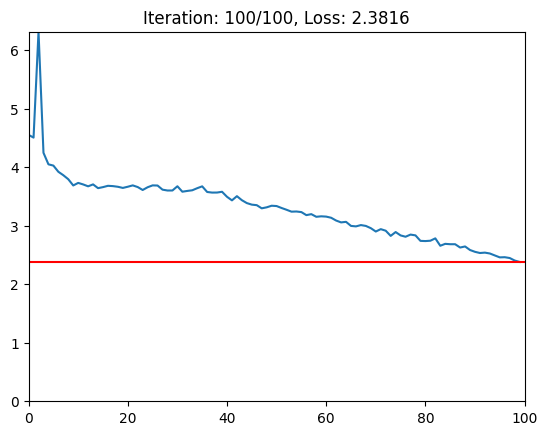

In [ ]:
# TRAINING
from IPython.display import clear_output
history = []
for iter in range(1,num_training_iterations+1):

  # Grabbing a batch of strings and propagate it through the nn
  x_batch, y_batch = get_batch(encode(data), batch_size, block_size)
  loss = train_step(x_batch, y_batch)
  # Updating the figure
  history.append(loss.numpy().mean())
  plt.xlim(0,num_training_iterations)
  plt.ylim(0,max(history))
  plt.plot(np.arange(0,iter),history)
  plt.axhline(loss.numpy().mean(),color='red')
  plt.title('Iteration: {}/{}, Loss: {:.4f}'.format(iter,num_training_iterations, loss.numpy().mean()))
  plt.show()
  clear_output(wait=True)

  # Updating the model with the changed weights
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Saving the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/my_ckpt'

In [ ]:
# Functions to be used

def generate_text(model, start_string, generation_length=1000):
  input_eval = encode(start_string)
  input_eval = tf.expand_dims(input_eval, 0)
  generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      # Removing the batch dimension
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # Passing the predicted output as the next step's input
      input_eval = tf.expand_dims([predicted_id], 0)
      # Appending the predicted index to the total output
      generated.append((predicted_id))

  return (start_string + ''.join(decode(generated)))


# The output is a long string of characters. This splits the strings into songs according to the abc file syntax.
import regex as re
def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs


In [ ]:
# New model with batch size 1 and I load the saved weights.
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            24320     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 95)             97375     
                                                                 
Total params: 5,368,671
Trainable params: 5,368,671
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# X is a good start string because it is the beginning for a new song
generated_text = generate_text(model, start_string="X", generation_length=500)
generated_songs = extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    waveform = play(song)
    # If its a valid song (correct syntax), lets play it!
    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)

100%|██████████| 500/500 [00:05<00:00, 99.96it/s] 

Found 0 songs in text
